# Project 3B: Learning Neural Networks

## Introduction
In this project, we will implement the *backpropagation* algorithm and apply it to the same problem as Project 3A, i.e. recognizing handwritten numeric digits.

In [26]:
import os
import numpy as np
from matplotlib import pyplot
from scipy import optimize
from scipy.io import loadmat
import utils

%matplotlib inline

## Neural Networks
In Project 3A, we implemented *feedforward* propagation in neural networks to recognize handwritten digits with the given parameters. In this project, we will implement the *backpropagation* algorithm to train the parameters for the neural network. First, we will load the dataset.

In [27]:
#  training data stored in arrays X, y
data = loadmat(os.path.join("data", "p3bdata1.mat"))
X, y = data["X"], data["y"].ravel()

# set the zero digit to 0, rather than its mapped 10 in this dataset
# This is an artifact due to the fact that this dataset was used in
# MATLAB where there is no index 0
y[y == 10] = 0

# Number of training examples
m = y.size

### Data visualization
We will start by visualizing part of our training data using the `displayData` function, which is the same one we used in Project 3A. The dataset is also the same as in the last project.
There are 5000 training examples in `p3data1.mat`, where each example is a grayscale image of 20x20 pixels. Each pixel is represented by a number (a float variable) indicating the intensity at that location. The 20x20 pixel network is extended into a vector of length 400. Each of these training examples is placed in a row of the `X` matrix. This makes the `X` matrix 5000x400, where each row is a training example with the image of the handwritten numeric digit.
$$ X = \begin{bmatrix} - \: (x^{(1)})^T \: - \\ -\: (x^{(2)})^T \:- \\ \vdots \\ - \: (x^{(m)})^T \:- \end{bmatrix} $$
The second part of the training data is the `y` vector of dimension 5000x1 and contains the labels (the correct digit present in each image). By executing the cell below, we will see some examples of our dataset.

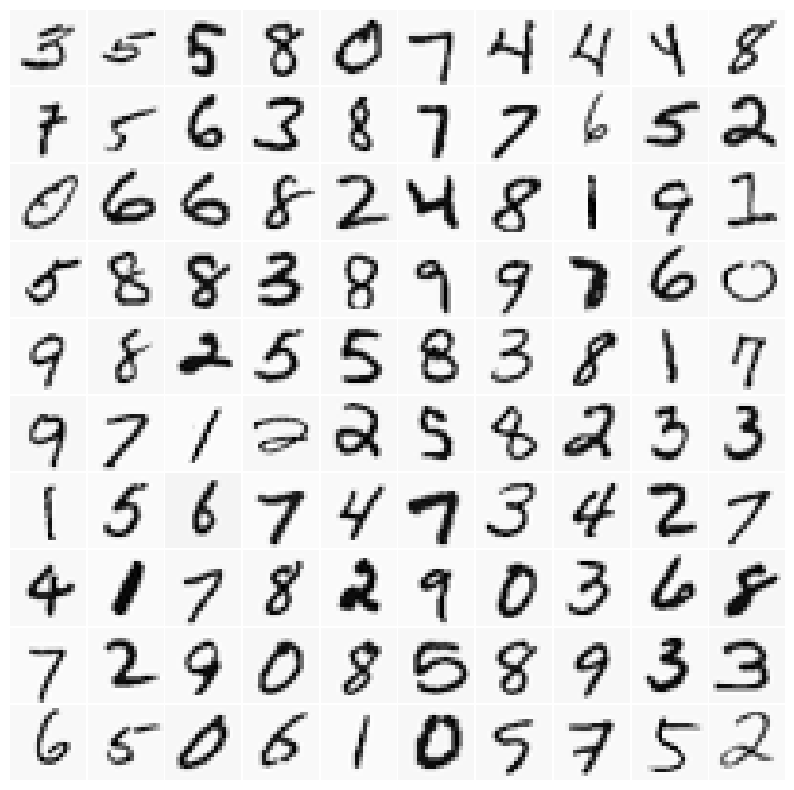

In [28]:
# Randomly select 100 data points to display
rand_indices = np.random.choice(m, 100, replace=False)
sel = X[rand_indices, :]

utils.displayData(sel)

### Representation of the model
Our neural network is shown in the following figure.

![](figures/neural_network.png)

This model has 3 layers: An input layer (*input layer*), a hidden layer (*hidden layer*) and an output layer (*output layer*). Note that its inputs are the intensity values of the pixels in the digit image. Knowing that the images are 20x20, this will result in an input layer of 400 units (excluding an extra unit of *bias* which always generates +1). As previously mentioned, the training data will be loaded into the variables `X` and `y`.
You have received a set of network parameters ($\Theta^{(1)}$, $\Theta^{(2)}$) that we have already trained. This is stored in the file `p3bweights.mat`. The next cell loads the parameters in `Theta1` and `Theta2`. The parameters have dimensions that are arranged for a neural network with 25 units in the second layer and 10 units in the output layer (corresponding to the 10 classes).

In [29]:
# Setup the parameters you will use for this exercise
input_layer_size = 400  # 20x20 Input Images of Digits
hidden_layer_size = 25  # 25 hidden units
num_labels = 10  # 10 labels, from 0 to 9

# Load the weights into variables Theta1 and Theta2
weights = loadmat(os.path.join("data/", "p3bweights.mat"))

# Theta1 has size 25 x 401
# Theta2 has size 10 x 26
Theta1, Theta2 = weights["Theta1"], weights["Theta2"]

# swap first and last columns of Theta2, due to legacy from MATLAB indexing,
# since the weight file ex3weights.mat was saved based on MATLAB indexing
Theta2 = np.roll(Theta2, 1, axis=0)

# Unroll parameters
nn_params = np.concatenate([Theta1.ravel(), Theta2.ravel()])

### Feedforward and cost function
Now we will implement the cost function and the gradient for the neural network. First, we have the code for the `nnCostFunction` function in the next cell to return the cost.
Note that the cost function for the neural network (without regularization) is:

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m}\sum_{k=1}^{K} \left[ - y_k^{(i)} \log \left( \left( h_\theta \left( x^{(i)} \right) \right)_k \right) - \left( 1 - y_k^{(i)} \right) \log \left( 1 - \left( h_\theta \left( x^{(i)} \right) \right)_k \right) \right]$$
where $h_\theta \left(x^{(i)} \right)$ is calculated as shown in the neural network figure above and K = 10 is the number of possible labels. Note that $h_\theta(x^{(i)})_k = a_k^{(3)}$ is the activation (output value) of the $k^{th}$ output unit. Also note that while the original labels (in the y variable) range from 0 to 9, for the purpose of training the neural network, we need to encode the labels as vectors containing only values of 0 or 1. Thus:
$$ y =
\begin{bmatrix} 1 \\ 0 \\ 0 \\vdots \\ 0 \end{bmatrix}, \quad
\begin{bmatrix} 0 \\ 1 \\ 0 \\ \vdots \\ 0 \end{bmatrix}, \quad \cdots \quad \text{or} \qquad
\begin{bmatrix} 0 \\ 0 \\ 0 \\ \vdots \\ 1 \end{bmatrix}.
$$

For this example, if $x^{(i)}$ is an image of the digit 5, then the corresponding $y^{(i)}$ (which you must use in the cost function) must be a vector of length 10 with $y_5 = 1$, and all other elements equal to 0.

We will implement *feedforward* propagation that calculates $h_\theta(x^{(i)})$ for each example $i$ and add up the cost of all the examples.

### Regularized cost function
The cost function of the neural network with regularization is given by:
$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m}\sum_{k=1}^{K} \left[ - y_k^{(i)} \log \left( \left( h_\theta \left( x^{(i)} \right) \right)_k \right) - \left( 1 - y_k^{(i)} \right) \log \left( 1 - \left( h_\theta \left( x^{(i)} \right) \right)_k \right) \right] + \frac{\lambda}{2 m} \left[ \sum_{j=1}^{25} \sum_{k=1}^{400} \left( \Theta_{j,k}^{(1)} \right)^2 + \sum_{j=1}^{10} \sum_{k=1}^{25} \left( \Theta_{j,k}^{(2)} \right)^2 \right] $$

In [30]:
def nnCostFunction(
    nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lambda_=0.0
):
    """
    Implements the neural network cost function and gradient for a two layer neural
    network which performs classification.

    Parameters
    ----------
    nn_params : array_like
        The parameters for the neural network which are "unrolled" into
        a vector. This needs to be converted back into the weight matrices Theta1
        and Theta2.

    input_layer_size : int
        Number of features for the input layer.

    hidden_layer_size : int
        Number of hidden units in the second layer.

    num_labels : int
        Total number of labels, or equivalently number of units in output layer.

    X : array_like
        Input dataset. A matrix of shape (m x input_layer_size).

    y : array_like
        Dataset labels. A vector of shape (m,).

    lambda_ : float, optional
        Regularization parameter.

    Returns
    -------
    J : float
        The computed value for the cost function at the current weight values.

    grad : array_like
        An "unrolled" vector of the partial derivatives of the concatenatation of
        neural network weights Theta1 and Theta2.
    """
    # Reshape nn_params back into the parameters Theta1 and Theta2, the weight matrices
    # for our 2 layer neural network
    Theta1 = np.reshape(
        nn_params[: hidden_layer_size * (input_layer_size + 1)],
        (hidden_layer_size, (input_layer_size + 1)),
    )

    Theta2 = np.reshape(
        nn_params[(hidden_layer_size * (input_layer_size + 1)) :],
        (num_labels, (hidden_layer_size + 1)),
    )

    # Setup some useful variables
    m = y.size
    J = 0
    Theta1_grad = np.zeros(Theta1.shape)
    Theta2_grad = np.zeros(Theta2.shape)
    # Convert labels to one-hot encoding
    y_onehot = np.zeros((m, num_labels))
    y_onehot[np.arange(m), y] = 1
    # Forward propagation
    a1 = np.insert(X, 0, 1, axis=1)  # Add bias unit to input layer
    z2 = a1.dot(Theta1.T)
    a2 = utils.sigmoid(z2)
    a2 = np.insert(a2, 0, 1, axis=1)  # Add bias unit to hidden layer
    z3 = a2.dot(Theta2.T)
    a3 = utils.sigmoid(z3)  # Output of the neural network
    # Compute the cost without regularization
    J = (-1 / m) * np.sum(y_onehot * np.log(a3) + (1 - y_onehot) * np.log(1 - a3))
    # Compute regularization term (excluding bias terms)
    reg_term = (lambda_ / (2 * m)) * (
        np.sum(Theta1[:, 1:] ** 2) + np.sum(Theta2[:, 1:] ** 2)
    )
    J = J + reg_term  # Add regularization term to the cost
    # Compute the gradients using backpropagation
    delta3 = a3 - y_onehot
    delta2 = delta3.dot(Theta2) * a2 * (1 - a2)
    delta2 = delta2[:, 1:]  # Remove delta for the bias unit
    Theta1_grad = (1 / m) * delta2.T.dot(a1)
    Theta2_grad = (1 / m) * delta3.T.dot(a2)
    # Add regularization to the gradients (except for the bias terms)
    Theta1_grad[:, 1:] += (lambda_ / m) * Theta1[:, 1:]
    Theta2_grad[:, 1:] += (lambda_ / m) * Theta2[:, 1:]
    # Unroll gradients
    grad = np.concatenate([Theta1_grad.ravel(), Theta2_grad.ravel()])
    return J, grad

Once finished, we will call the `nnCostFunction` function using the parameters loaded for `Theta1` and `Theta2`.

In [31]:
lambda_ = 0
J, _ = nnCostFunction(
    nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lambda_
)
print("Cost at parameters (loaded from p3bweights): %.6f " % J)
print("The cost should be about                   : 0.287629.")

Cost at parameters (loaded from p3bweights): 0.287629 
The cost should be about                   : 0.287629.


Once finished, the next cell will call `nnCostFunction` using the parameters loaded from `Theta1` and `Theta2`, and $\lambda = 1$.

In [32]:
# Weight regularization parameter (we set this to 1 here).
lambda_ = 1
J, _ = nnCostFunction(
    nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lambda_
)

print("Cost for the parameters (loaded from p3bweights): %.6f" % J)
print("The cost should be about                        : 0.383770.")

Cost for the parameters (loaded from p3bweights): 0.383770
The cost should be about                        : 0.383770.


## Backpropagation

In this section of the project, we will implement the *backpropagation* algorithm to calculate the gradient of the neural network's cost function. We will update the `nnCostFunction` function which will then return an appropriate value for `grad`. Once the gradient has been obtained, we will be able to train the neural network to minimize the cost function $J(\theta)$ using an advanced optimizer.

We will first implement the *backpropagation* algorithm to calculate the gradient for the parameters of the (unregularized) neural network. After checking that the gradient calculation for the unregularized case is correct, we will implement the gradient for the regularized neural network.

### Sigmoid gradient
First, we will implement the gradient of the sigmoid function. The gradient for the sigmoid function can be calculated as

$$ g'(z) = \frac{d}{dz} g(z) = g(z)\left(1-g(z)\right) $$
where
$$ \text{sigmoid}(z) = g(z) = \frac{1}{1 + e^{-z}} $$

In [33]:
def sigmoidGradient(z):
    """
    Computes the gradient of the sigmoid function evaluated at z.
    This should work regardless if z is a matrix or a vector.
    In particular, if z is a vector or matrix, you should return
    the gradient for each element.

    Parameters
    ----------
    z : array_like
        A vector or matrix as input to the sigmoid function.

    Returns
    --------
    g : array_like
        Gradient of the sigmoid function. Has the same shape as z.
    """
    g = np.zeros(z.shape)
    sigmoid_z = utils.sigmoid(z)
    g = sigmoid_z * (1 - sigmoid_z)
    return g

Once this is done, the next cell will call `sigmoidGradient` in the `z` vector. When $z = 0$, the gradient must be exactly 0.25.

In [34]:
z = np.array([-1, -0.5, 0, 0.5, 1])
g = sigmoidGradient(z)
print("Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1]:")
print(g)

Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1]:
[0.19661193 0.23500371 0.25       0.23500371 0.19661193]


## Random initialization

When training neural networks, it is important to randomize the initialization of the parameters to break the symmetry. An effective strategy for randomizing the initialization is to randomize the selected values of $\Theta^{(l)}$ uniformly in the range $[-\epsilon_{init}, \epsilon_{init}]$. We will use $\epsilon_{init} = 0.12$. This range of values ensures that the parameters are kept low, which makes learning more efficient.

An effective strategy for choosing $\epsilon_{init}$ is to base it on the number of units in the network. A good choice of $\epsilon_{init}$ is $\epsilon_{init} = \frac{\sqrt{6}}{\sqrt{L_{in} + L_{out}}}$ where $L_{in} = s_l$ and $L_{out} = s_{l+1}$ is the number of units in the adjacent layers for $\Theta^{l}$.
Next, the `randInitializeWeights` function will be implemented to initialize the weights for $\Theta$.

In [35]:
def randInitializeWeights(L_in, L_out, epsilon_init=0.12):
    """
    Randomly initialize the weights of a layer in a neural network.

    Parameters
    ----------
    L_in : int
        Number of incomming connections.

    L_out : int
        Number of outgoing connections.

    epsilon_init : float, optional
        Range of values which the weight can take from a uniform
        distribution.

    Returns
    -------
    W : array_like
        The weight initialiatized to random values.  Note that W should
        be set to a matrix of size(L_out, 1 + L_in) as
        the first column of W handles the "bias" terms.
    """
    W = np.zeros((L_out, 1 + L_in))
    W = np.random.rand(L_out, 1 + L_in) * 2 * epsilon_init - epsilon_init
    return W

We will run the next cell to initialize the weights for the two layers of the neural network using the `randInitializeWeights` function.

In [36]:
print("Initializing the neural network parameters...")

initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)

# Unroll parameters
initial_nn_params = np.concatenate(
    [initial_Theta1.ravel(), initial_Theta2.ravel()], axis=0
)

Initializing the neural network parameters...


### Backpropagation

![](figures/ex4-backpropagation.png)

Now we're going to implement the *backpropagation* algorithm. Recall that the intuition behind the *backpropagation* algorithm is as follows. Given a training example $(x^{(t)}, y^{(t)})$, we will first perform a*feedforward pass* to calculate all the activations along the network, including the output value of the hypothesis $h_\theta(x)$. So, for each node $j$ in layer $l$, we want to calculate the “error term” $\delta_j^{(l)}$ which measures how much the node is “responsible” for any error in our output.

For an output node, we can directly measure the difference between the network activation and the true target value and use this to define $\delta_j^{(3)}$ (since layer 3 is the output layer). For the hidden units, you will calculate $\delta_j^{(l)}$ based on the weighted average of the error terms of the nodes in layer $(l+1)$. You should implement steps 1 to 4 in a loop that processes one example at a time. Concretely, you should implement a for `for t in range(m)` loop and place steps 1 to 4 below inside the loop, with the $t^{th}$ iteration performing the calculation on the $t^{th}$ training example $(x^{(t)},y^{(t)})$. Step 5 will divide the accumulated gradients by $m$ to obtain the gradients for the neural network's cost function.

1. Select the input layer values $(a^{(1)})$ for the $t^{th }$ training examples $x^{(t)}$. Perform a direct pass, calculating the activations $(z^{(2)}, a^{(2)}, z^{(3)}, a^{(3)})$ for layers 2 and 3. Note that you need to add a `+1` term to make sure that the activation vectors for layers $a^{(1)}$ and $a^{(2)}$ also include the unit *bias*. In `numpy`, if `a_1` is a column matrix, adding a column of `1` corresponds to `a_1 = np.concatenate([np.ones((m, 1)), a_1], axis=1)`.

1. For each output unit $k$ in layer 3 (the output layer), define
$$\delta_k^{(3)} = \left (a_k^{(3)} - y_k \right)$$
where $ y_k \in \{0, 1\} $ indicates whether the current training example belongs to class $k$ $(y_k = 1)$ or whether it belongs to a different class $ (y_k = 0)$. You can find useful logical matrices for this task (explained in Project 3A).

1. For the hidden layer $ l = 2 $, define
$$ \delta^{(2)} = \left (\Theta^{(2)} \right)^T \delta^{(3)} * g'\left(z^{(2)} \right)$$
Note that the symbol $ * $ performs multiplication by elements in `numpy`.

1. Accumulate the gradient of this example using the following formula. Note that you must skip or remove $ \delta_0^{(2)}$. In `numpy`, removing $ \delta_0^{(2)}$ corresponds to `delta_2 = delta_2[1:] `.
$$ \Delta^{(l)} = \Delta^{(l)} + \delta^{(l + 1)} (a^{(l)})^{(T)}$$

1. Obtain the (unregularized) gradient for the cost function of the neural network by dividing the accumulated gradients by $ \frac{1} {m}$:
$$ \frac{\partial}{\partial \Theta_{ij}^{(l)}} J(\Theta) = D_{ij}^{(l)} = \frac{1}{m} \Delta_{ij}^{(l)}$$

Go back and check the `nnCostFunction` with the *backpropagation* algorithm.

After implementing the *backpropagation* algorithm, we will perform gradient checking on your implementation. Gradient checking will increase confidence that your code is calculating gradients correctly.

### Gradient checking  

In our neural network, we are minimizing the cost function $J(\Theta)$. To use gradient checking on our parameters, we can imagine that we are “unrolling” the parameters $\Theta^{(1)}$ and $\Theta^{(2)}$ into a single vector $\theta$. In doing so, we can think of the cost function as $J(\Theta)$ and use the following gradient checking procedure.
Suppose we have the function $f_i(\theta)$ which is supposed to calculate $\frac{\partial}{\partial \theta_i} J(\theta)$; we would like to check that $f_i$ is producing correct derivative values.

$$
\text{Seja } \theta^{(i+)} = \theta + \begin{bmatrix} 0 \\ 0 \\ \vdots \\ \epsilon \\ \vdots \\ 0 \end{bmatrix}
\quad \text{e} \quad \theta^{(i-)} = \theta - \begin{bmatrix} 0 \\ 0 \\ \vdots \\ \epsilon \\ \vdots \\ 0 \end{bmatrix}
$$

So, $\theta^{(i+)}$ is equal to $\theta$, except for the $i^{th}$ element, which has been added by $\epsilon$. Similarly, $\theta^{(i-)}$ is equal to the vector $\theta$, except for the $i^{th}$ element, which has been decreased by $\epsilon$. We can now numerically check the correctness of the $f_i(\theta)$'s by checking for each $i$:

$$ f_i\left( \theta \right) \approx \frac{J\left( \theta^{(i+)}\right) - J\left( \theta^{(i-)} \right)}{2\epsilon} $$

How close these two values are depends on $J$. But, assuming $ \epsilon = 10 ^ {- 4} $, we will generally find that the left and right sides must agree on at least the 4 most significant digits.

In the next cell we will run the supplied function `checkNNGradients` with which we will create a small neural network and the dataset that will be used to check our gradients.

In [37]:
utils.checkNNGradients(nnCostFunction)

[[-9.27825235e-03 -9.27825236e-03]
 [-3.04978709e-06 -3.04978914e-06]
 [-1.75060084e-04 -1.75060082e-04]
 [-9.62660640e-05 -9.62660620e-05]
 [ 8.89911959e-03  8.89911960e-03]
 [ 1.42869450e-05  1.42869443e-05]
 [ 2.33146358e-04  2.33146357e-04]
 [ 1.17982666e-04  1.17982666e-04]
 [-8.36010761e-03 -8.36010762e-03]
 [-2.59383093e-05 -2.59383100e-05]
 [-2.87468729e-04 -2.87468729e-04]
 [-1.37149709e-04 -1.37149706e-04]
 [ 7.62813550e-03  7.62813551e-03]
 [ 3.69883257e-05  3.69883234e-05]
 [ 3.35320351e-04  3.35320347e-04]
 [ 1.53247082e-04  1.53247082e-04]
 [-6.74798369e-03 -6.74798370e-03]
 [-4.68759764e-05 -4.68759769e-05]
 [-3.76215583e-04 -3.76215587e-04]
 [-1.66560294e-04 -1.66560294e-04]
 [ 3.14544970e-01  3.14544970e-01]
 [ 1.64090819e-01  1.64090819e-01]
 [ 1.64567932e-01  1.64567932e-01]
 [ 1.58339334e-01  1.58339334e-01]
 [ 1.51127527e-01  1.51127527e-01]
 [ 1.49568335e-01  1.49568335e-01]
 [ 1.11056588e-01  1.11056588e-01]
 [ 5.75736494e-02  5.75736493e-02]
 [ 5.77867378e-02  5

### Regularized Neural Network

After implementing the *backpropagation* algorithm correctly, gradient regularization was added. To take regularization into account, it was enough to add an additional term after calculating the gradients using the *backpropagation* algorithm.

Specifically, after calculating $\Delta_{ij}^{(l)}$ using the *backpropagation* algorithm, we added the regularization using

$$ \begin{align}
& \frac{\partial}{\partial \Theta_{ij}^{(l)}} J(\Theta) = D_{ij}^{(l)} = \frac{1}{m} \Delta_{ij}^{(l)} & \qquad \text{for } j = 0 \\
& \frac{\partial}{\partial \Theta_{ij}^{(l)}} J(\Theta) = D_{ij}^{(l)} = \frac{1}{m} \Delta_{ij}^{(l)} + \frac{\lambda}{m} \Theta_{ij}^{(l)} & \qquad \text{for } j \ge 1
\end{align}
$$

Note that we should NOT regularize the first column of $\Theta^{(l)}$, since it is used to accommodate bias terms. Furthermore, in the parameters $\Theta_{ij}^{(l)}$, $i$ is indexed starting at 1 and $j$ is indexed starting at 0. Thus,

$$
\Theta^{(l)} = \begin{bmatrix}
\Theta_{1,0}^{(i)} & \Theta_{1,1}^{(l)} & \cdots \\
\Theta_{2,0}^{(i)} & \Theta_{2,1}^{(l)} & \cdots \\
\vdots & ~ & \ddots
\end{bmatrix}
$$

The next cell will perform the gradient check in our implementation.

In [38]:
#  Check gradients by running checkNNGradients
lambda_ = 3
utils.checkNNGradients(nnCostFunction, lambda_)

# Also output the costFunction debugging values
debug_J, _ = nnCostFunction(
    nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lambda_
)

print(
    "\n\nCost at (fixed) debugging parameters (w/ lambda = %f): %f "
    % (lambda_, debug_J)
)
print("(for lambda = 3, this value should be about 0.576051)")

[[-9.27825235e-03 -9.27825236e-03]
 [-1.67679797e-02 -1.67679797e-02]
 [-6.01744725e-02 -6.01744725e-02]
 [-1.73704651e-02 -1.73704651e-02]
 [ 8.89911959e-03  8.89911960e-03]
 [ 3.94334829e-02  3.94334829e-02]
 [-3.19612287e-02 -3.19612287e-02]
 [-5.75658668e-02 -5.75658668e-02]
 [-8.36010761e-03 -8.36010762e-03]
 [ 5.93355565e-02  5.93355565e-02]
 [ 2.49225535e-02  2.49225535e-02]
 [-4.51963845e-02 -4.51963845e-02]
 [ 7.62813550e-03  7.62813551e-03]
 [ 2.47640974e-02  2.47640974e-02]
 [ 5.97717617e-02  5.97717617e-02]
 [ 9.14587966e-03  9.14587966e-03]
 [-6.74798369e-03 -6.74798370e-03]
 [-3.26881426e-02 -3.26881426e-02]
 [ 3.86410548e-02  3.86410548e-02]
 [ 5.46101547e-02  5.46101547e-02]
 [ 3.14544970e-01  3.14544970e-01]
 [ 1.18682669e-01  1.18682669e-01]
 [ 2.03987128e-01  2.03987128e-01]
 [ 1.25698067e-01  1.25698067e-01]
 [ 1.76337550e-01  1.76337550e-01]
 [ 1.32294136e-01  1.32294136e-01]
 [ 1.11056588e-01  1.11056588e-01]
 [ 3.81928689e-05  3.81928696e-05]
 [ 1.17148233e-01  1

### Parameter learning using `scipy.optimize.minimize`

After implementing the neural network's cost function and calculating the gradient, the next step is to use `scipy` minimization to learn good parameters.

In [39]:
#  You should try different values of lambda
lambda_ = 1

# Create "short hand" for the cost function to be minimized
costFunction = lambda p: nnCostFunction(
    p, input_layer_size, hidden_layer_size, num_labels, X, y, lambda_
)

# Now, costFunction is a function that takes in only one argument
# (the neural network parameters)
res = optimize.minimize(
    costFunction, initial_nn_params, jac=True, method="TNC"
)

# get the solution of the optimization
nn_params = res.x

# Obtain Theta1 and Theta2 back from nn_params
Theta1 = np.reshape(
    nn_params[: hidden_layer_size * (input_layer_size + 1)],
    (hidden_layer_size, (input_layer_size + 1)),
)

Theta2 = np.reshape(
    nn_params[(hidden_layer_size * (input_layer_size + 1)) :],
    (num_labels, (hidden_layer_size + 1)),
)

After completing the training, we will calculate the training accuracy of our classifier by calculating the percentage of correct examples. If our implementation is correct, we will obtain a training accuracy of around 95.3% (this can vary by approximately 1% due to random initialization). It is possible to obtain higher accuracies by training the neural network in more iterations.

In [40]:
pred = utils.predict(Theta1, Theta2, X)
print("Training accuracy: %f" % (np.mean(pred == y) * 100))

Training accuracy: 99.740000


## Visualizing the Hidden Layer

One way of understanding what the neural network is learning is to visualize what representations are captured by the hidden layer units. Informally, given a particular hidden layer unit, one way to visualize what is being calculated is to find an input $x$ that will cause it to activate (i.e. have an activation value ($ a_i^{(l)}$) close to 1). For the neural network we trained, note that the $i^{th}$ row of $\Theta^{(1)}$ is a vector of size 401 that represents the parameter for the $i^{th}$ unit of the hidden layer. If we discard the *bias* term, we get a vector of size 400 representing the weights of each input pixel of the hidden layer.

So, one way to visualize the “representation” captured by the hidden layer unit is to reshape this vector of size 400 into a 20x20 image and display it (this is equivalent to finding the input that offers the greatest activation for the hidden unit, given a “norm” constraint on the input (i.e. $ ||x|_2 \le 1 $)).

The next cell does this using the `displayData` function and this is shown in an image with 25 units, each corresponding to a unit of the network's hidden layer. In our trained network, you should find that the hidden layer units roughly correspond to the detectors that look for traces and other patterns in the input.

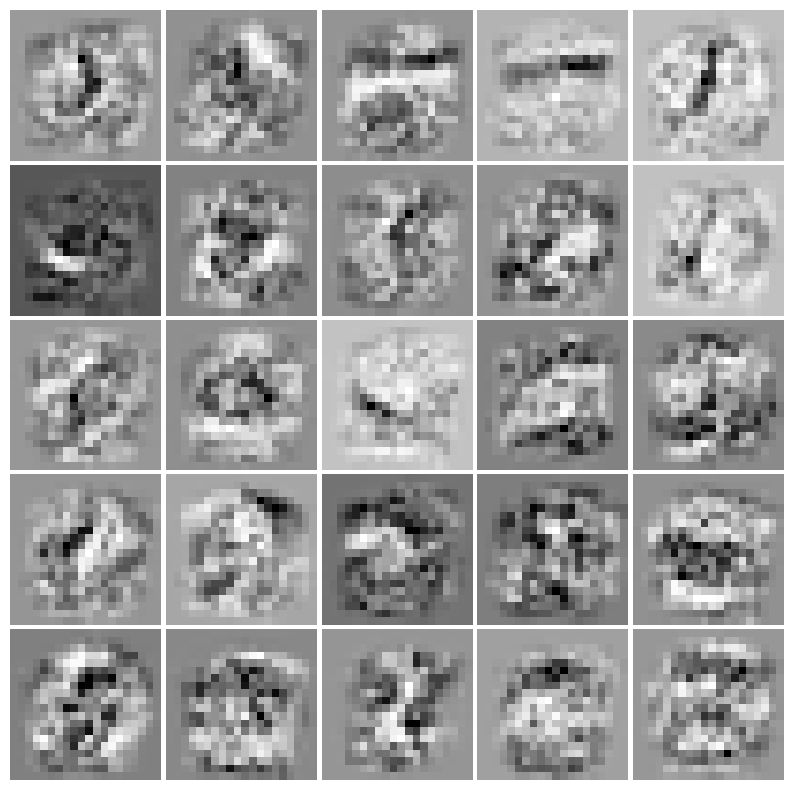

In [41]:
utils.displayData(Theta1[:, 1:])

# Comparison with PyTorch

Now, we will build the same neural network for classification presented in the previous sections, but instead of building the functions that execute each step of the neural network, we will use the functions available in the Pytorch library.

In [42]:
import torch
from torch.utils.data import DataLoader, TensorDataset

### Creating the model

The structure of our neural network will be the same as that presented in subsection 1.2, in which we have an input layer, a hidden layer and an output layer. We will now build this network using Pytorch. Recalling the structure, we have

- An input layer with Linear activation function with:

        -> Input: 400 
        -> Output: 25 
        -> Bias: True 
    
- A hidden layer with Sigmoid activation function with:

        -> Input: 25  
        -> Output: 10 
        -> Bias: True 

- And the output layer containing the outputs with the 10 expected classes (one for each digit).

So, we'll build our neural network from the NeuralNetwork class. This class is initialized by defining the `fc1` and `fc2` functions, which perform linear transformations on the data in each layer, the former in the input layer (with 400 inputs and 25 outputs) and the latter in the hidden layer (with 25 inputs and 10 outputs).
Next, we'll define the forward() function which executes the Sigmoid function as the activation functions for the two layers in question.

In [43]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(in_features=400, out_features=25, bias=True)
        self.fc2 = torch.nn.Linear(in_features=25, out_features=10, bias=True)

    def forward(self, out):
        out = torch.sigmoid(self.fc1(out))
        out = torch.sigmoid(self.fc2(out))
        return out

### Processing and handling the input data

Once the structure of the neural network has been created, we need to process the input data, adapting it to a format in which the class we have created can process it in order to learn the network's parameters. First, we'll re-import the project data.

In [44]:
# Import the data
datas = loadmat("data/p3bdata1.mat")
datas.keys()

label, images = datas["y"], datas["X"]
# This is an artifact due to the fact that this dataset was used in
# MATLAB where there is no index 0
label = label - 1

With the data imported and basically adjusted, we will transform it into tensors before creating the dataset. To do this, we'll use the `torch.Tensor()` and `torch.LongTensor()` methods. The difference between the two is that the former accepts values of type `float` (more specifically `float32`) while the latter accepts values of type `int` (more specifically `int64`).

In [45]:
# Transform the inputs and labels into tensors
tensor_images, tensor_label = torch.Tensor(images), torch.LongTensor(label)

Once this is done, we can create our dataset which will be used to train the neural network. To do this, we will use the `TensorDataset` and `DataLoader` functions.

In these functions, we will select the desired size for the *batch*, as well as the option to*shuffle* the data to improve the performance of the neural network.

In [46]:
# Batch Size
batch_size = 35

# Creating the dataset with the two tensors
dataset = TensorDataset(tensor_images, tensor_label)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

### Training the Neural Network

To train the neural network, it is necessary to choose which cost function will be used and which algorithm will optimize the network parameters.

PyTorch provides several types of cost function within the `torch.nn` module. Among the best known are *Cross Entropy* and *mean squared error*. As for the optimization algorithm, the library also provides several types, among the best known are the *Gradient Descent*, the *Stochastic Gradient Descent* and Adam. In our program, we chose *Cross Entropy* for the cost function and, as the optimization algorithm, we chose *Stochastic Gradient Descent* with initial values of *learning rate* of 0.5 and *momentum* of 0.9.

With everything set up, we can instantiate our neural network in the `model` variable

In [47]:
# Instantiate the NN into variable model
model = NeuralNetwork()

# Definition of cost function
criterion = torch.nn.CrossEntropyLoss()

# Definition of SGD as optimizer algorithm and its parameter sets
optimizer = torch.optim.SGD(model.parameters(), lr=0.5, momentum=0.9)

We will print the `model` variable so that we can see its details.

In [48]:
print(model)

NeuralNetwork(
  (fc1): Linear(in_features=400, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=10, bias=True)
)


Once the training data has been processed correctly and the model has been properly instantiated with the cost function and optimization algorithm configured, we must build the network's training loop.

We will first choose the number of epochs that our neural network will go through in this training stage. In each of these epochs, the neural network must create another loop in which each example of the dataloader will be explored, calculating the error and optimizing the parameters at the end of each of these examples.

In [49]:
def training(NN, dataloader, criterion, lr=0.5):
    """
    Train the neural network to improve the predictions and, consequently,
    the accuracy os the model.

    Parameters
    ----------
    NN : class_like
        A class that contains the structure of neural network.

    dataloader: class_like
        A class that contains the training data set with images and labels.

    criterion: class_like
        A class that contains the cost function.

    lr: float_like
        The number of the learning rate. By default, it is equal to 0.5.

    Returns
    --------
    costs : list_like
        List of cost function values ​​for each epoch.

    accs : list_like
        List of accuracy values for each epoch.
    """

    # Recreates the model and the optimizer to ensure that we will not train an already trained model.
    model = NN
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    # Define the number os epochs.
    num_epochs = 100

    # Creation of variables to save train data
    cost = torch.zeros([])
    output = torch.zeros(batch_size, 10)
    costs = []
    accs = []

    # Loop that will run the code num_epoch times
    for epoch in range(num_epochs):
        # Variables to calculate accuracy
        correct = 0
        total = 0

        # Indicate that model is on train mode
        model.train()
        for data, label in dataloader:
            output = model(data) # Pass input data through model
            # Compute cost function
            cost = criterion(output, label.reshape(output.shape[0]))
            optimizer.zero_grad() # Compute the gradients obtained from model
            cost.backward() # Execute backpropagation
            optimizer.step() # Update parameters od model
            # Counting of correct labels and total examples
            out2 = torch.log_softmax(output, dim=1)
            _, predict = torch.max(out2, dim=1)
            for i in range(0, len(label)):
                total = total + 1
                if predict[i] == label[i]:
                    correct = correct + 1

        # Computation of accuracy
        acc = (
            correct / total
        ) * 100  # Calcula a acurácia para erro absoluto de 1 grau em porcentagem

        # Adding elements to lists
        accs.append(acc)  # Adiciona essa acurácia a sua lista
        costs.append(cost.item())

        print("epoch [{}/{}], cost:{:.4f}".format(epoch + 1, num_epochs, cost.item()))

    return costs, accs

In the `training` function we run the neural network training and, within the loop, we have already collected the values of the cost function and accuracy at each epoch, storing them in two lists that are returned at the end of our function.

In [50]:
costs, accs = training(NN=NeuralNetwork(), dataloader=dataloader, criterion=criterion)

epoch [1/100], cost:1.6887
epoch [2/100], cost:1.6005
epoch [3/100], cost:1.5316
epoch [4/100], cost:1.6216
epoch [5/100], cost:1.6208
epoch [6/100], cost:1.5511
epoch [7/100], cost:1.5271
epoch [8/100], cost:1.4984
epoch [9/100], cost:1.5134
epoch [10/100], cost:1.4762
epoch [11/100], cost:1.5546
epoch [12/100], cost:1.5451
epoch [13/100], cost:1.5294
epoch [14/100], cost:1.4843
epoch [15/100], cost:1.5152
epoch [16/100], cost:1.4884
epoch [17/100], cost:1.5419
epoch [18/100], cost:1.4684
epoch [19/100], cost:1.5129
epoch [20/100], cost:1.4982
epoch [21/100], cost:1.4875
epoch [22/100], cost:1.5364
epoch [23/100], cost:1.5468
epoch [24/100], cost:1.5064
epoch [25/100], cost:1.4722
epoch [26/100], cost:1.4717
epoch [27/100], cost:1.4677
epoch [28/100], cost:1.5073
epoch [29/100], cost:1.4794
epoch [30/100], cost:1.5106
epoch [31/100], cost:1.4896
epoch [32/100], cost:1.4705
epoch [33/100], cost:1.4686
epoch [34/100], cost:1.4814
epoch [35/100], cost:1.4717
epoch [36/100], cost:1.4728
e

With the network trained, we can plot the values of the cost function as a function of the number of epochs, so that we can analyze its behavior and see if it has converged as expected. The cell below plots the two graphs (of the loss function and accuracy). It is expected that, at the end of the 100 epochs, the loss function will be between 1.45 and 1.55 and the accuracy will be above 95%.

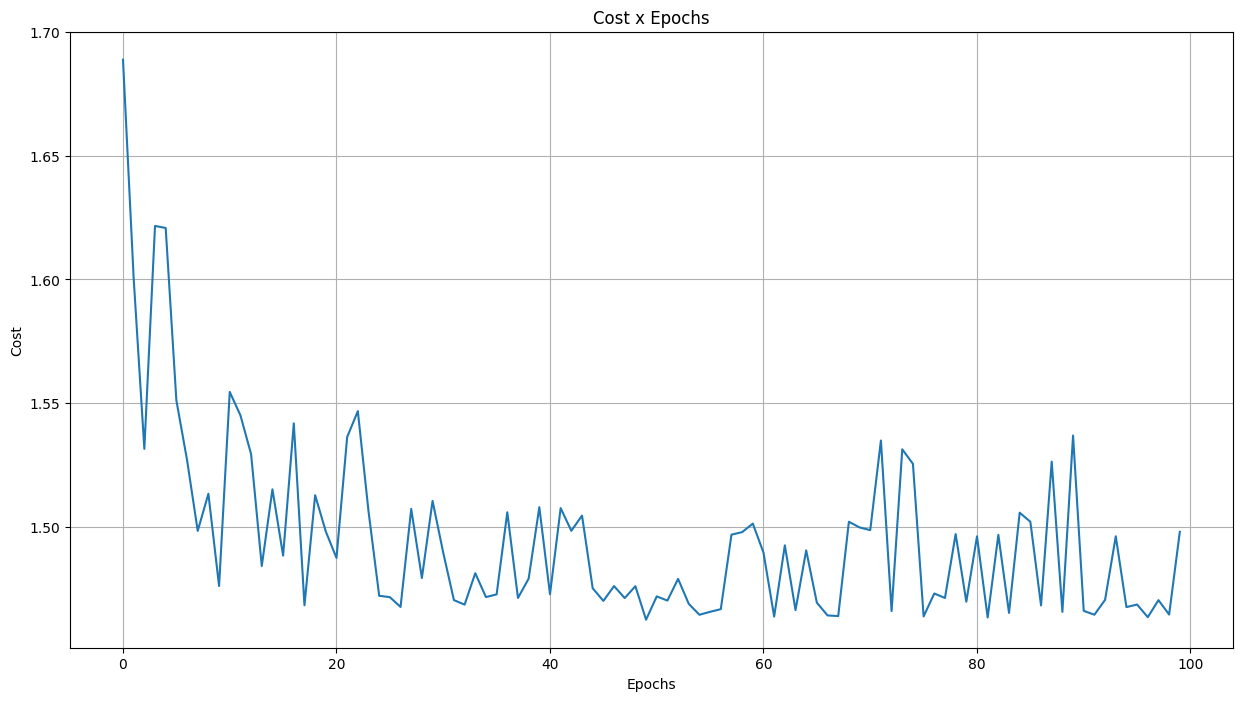

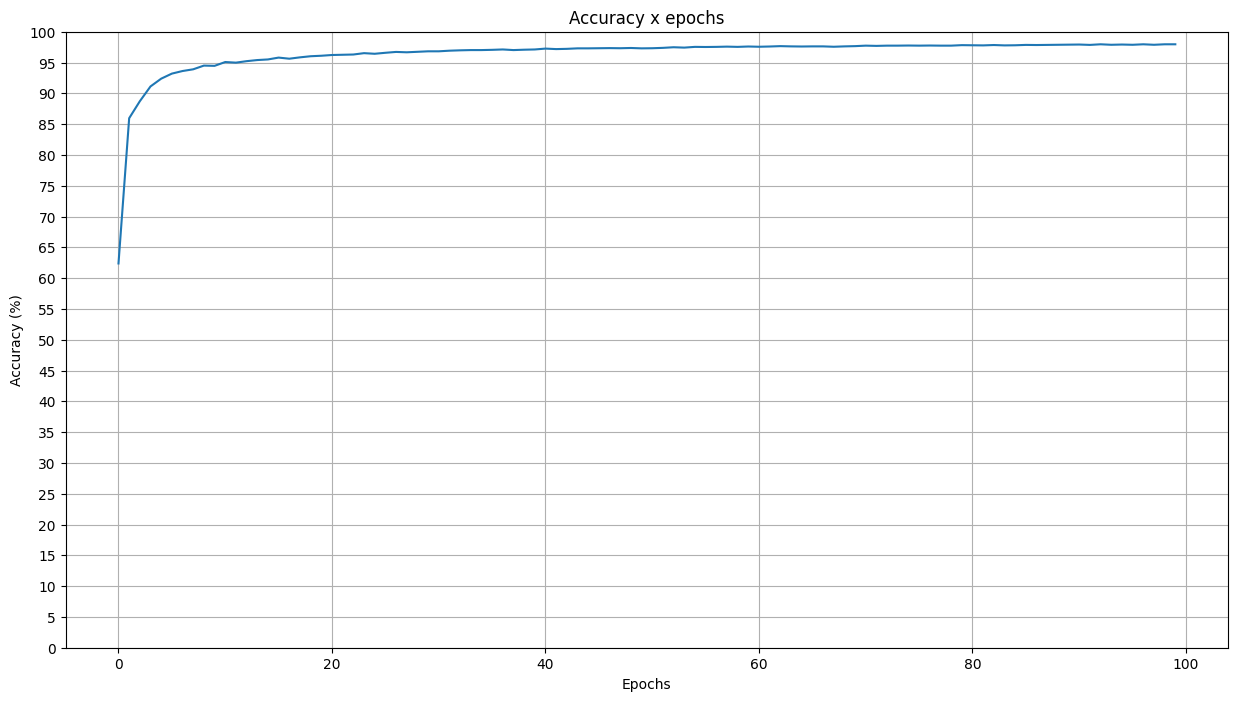

In [51]:
pyplot.figure(figsize=(15, 8))
pyplot.plot(costs)
pyplot.title("Cost x Epochs")
pyplot.xlabel("Epochs")
pyplot.ylabel("Cost")
pyplot.grid(True)
pyplot.show()

pyplot.figure(figsize=(15, 8))
pyplot.plot(accs)
pyplot.yticks(range(0, 101, 5))
pyplot.title("Accuracy x epochs")
pyplot.xlabel("Epochs")
pyplot.ylabel("Accuracy (%)")
pyplot.grid(True)
pyplot.show()

We will now see how these two curves behave when we change the value of the *learning rate*. We will now train the network with different `lr` values: `lr=0.005`, `lr=0.015`, `lr=15` and `lr=50`.

In [52]:
costs_lr0005, accs_lr0005 = training(
    NN=NeuralNetwork(), dataloader=dataloader, criterion=criterion, lr=0.005
)
costs_lr0015, accs_lr0015 = training(
    NN=NeuralNetwork(), dataloader=dataloader, criterion=criterion, lr=0.015
)
costs_lr15, accs_lr15 = training(
    NN=NeuralNetwork(), dataloader=dataloader, criterion=criterion, lr=15
)
costs_lr50, accs_lr50 = training(
    NN=NeuralNetwork(), dataloader=dataloader, criterion=criterion, lr=50
)

epoch [1/100], cost:2.3154
epoch [2/100], cost:2.2968
epoch [3/100], cost:2.2875
epoch [4/100], cost:2.2897
epoch [5/100], cost:2.2807
epoch [6/100], cost:2.2583
epoch [7/100], cost:2.2493
epoch [8/100], cost:2.2443
epoch [9/100], cost:2.2292
epoch [10/100], cost:2.2193
epoch [11/100], cost:2.1912
epoch [12/100], cost:2.1586
epoch [13/100], cost:2.1664
epoch [14/100], cost:2.1194
epoch [15/100], cost:2.1265
epoch [16/100], cost:2.0773
epoch [17/100], cost:2.0447
epoch [18/100], cost:2.0181
epoch [19/100], cost:2.0192
epoch [20/100], cost:1.9915
epoch [21/100], cost:1.9662
epoch [22/100], cost:1.9527
epoch [23/100], cost:1.9800
epoch [24/100], cost:2.0001
epoch [25/100], cost:1.9013
epoch [26/100], cost:1.9144
epoch [27/100], cost:1.9080
epoch [28/100], cost:1.8461
epoch [29/100], cost:1.8460
epoch [30/100], cost:1.8748
epoch [31/100], cost:1.8685
epoch [32/100], cost:1.8450
epoch [33/100], cost:1.8061
epoch [34/100], cost:1.7953
epoch [35/100], cost:1.8409
epoch [36/100], cost:1.8149
e

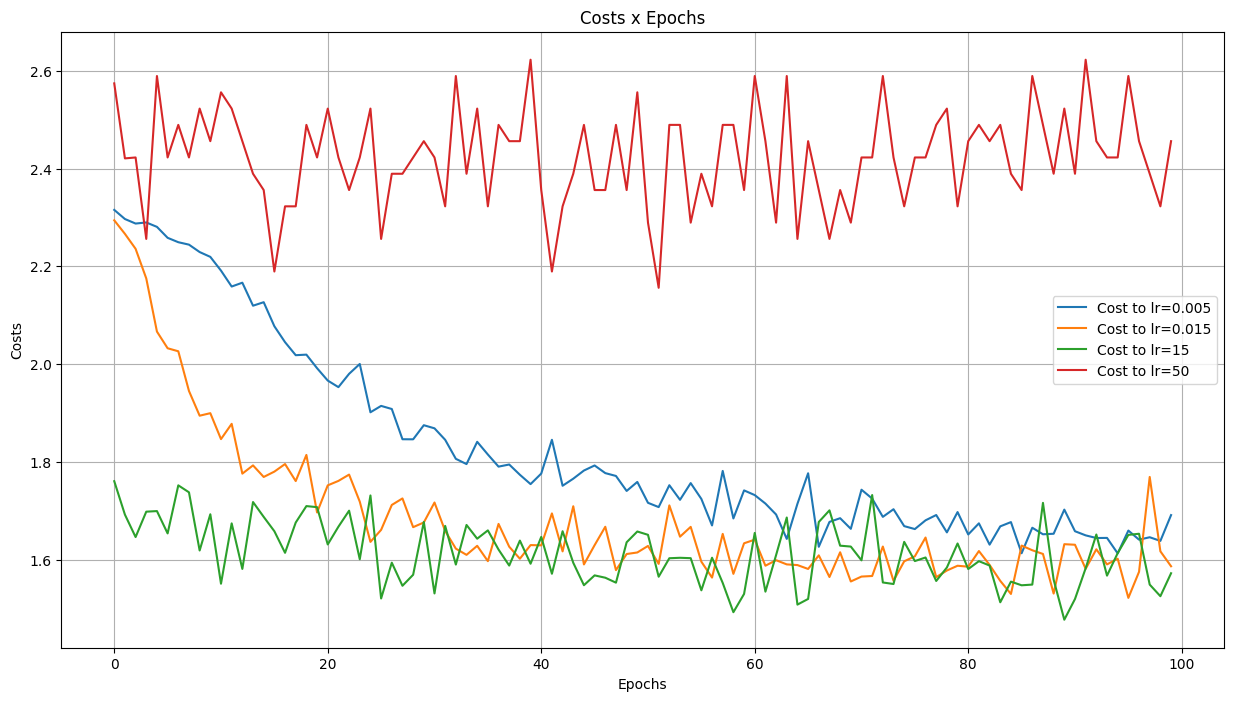

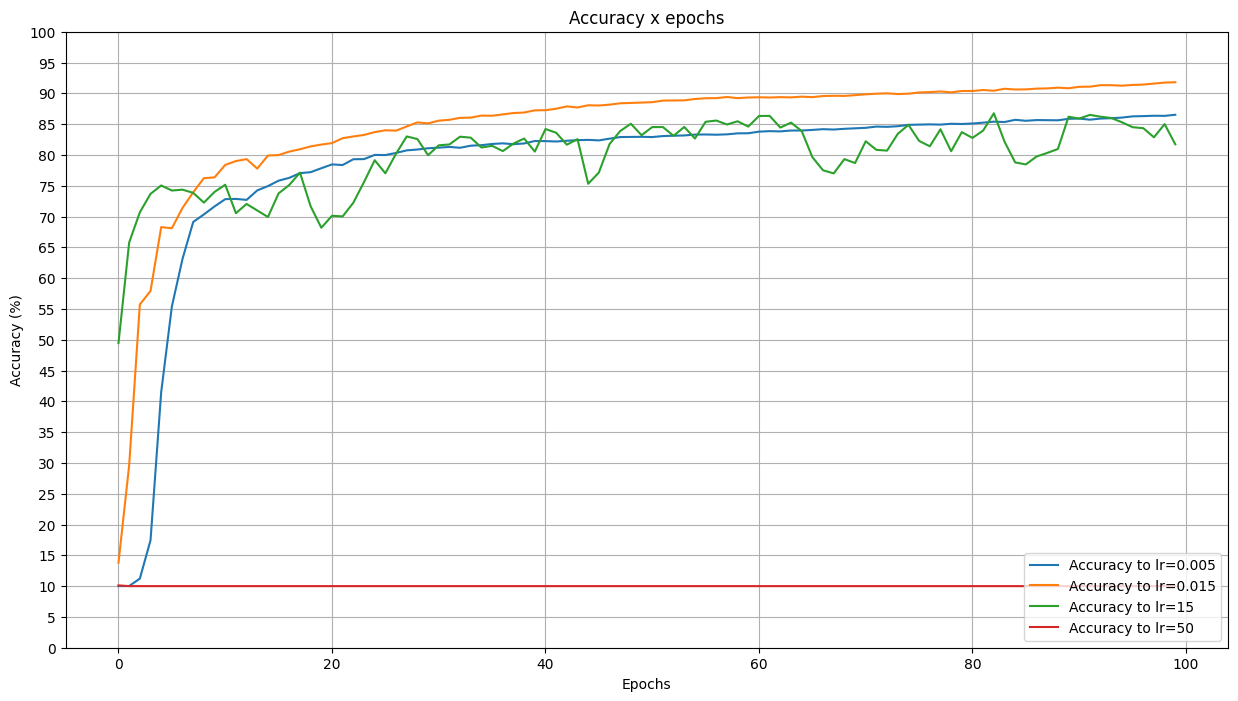

In [53]:
pyplot.figure(figsize=(15, 8))
pyplot.plot(costs_lr0005, label="Cost to lr=0.005")
pyplot.plot(costs_lr0015, label="Cost to lr=0.015")
pyplot.plot(costs_lr15, label="Cost to lr=15")
pyplot.plot(costs_lr50, label="Cost to lr=50")
pyplot.title("Costs x Epochs")
pyplot.xlabel("Epochs")
pyplot.ylabel("Costs")
pyplot.legend()
pyplot.grid(True)
pyplot.show()

pyplot.figure(figsize=(15, 8))
pyplot.plot(accs_lr0005, label="Accuracy to lr=0.005")
pyplot.plot(accs_lr0015, label="Accuracy to lr=0.015")
pyplot.plot(accs_lr15, label="Accuracy to lr=15")
pyplot.plot(accs_lr50, label="Accuracy to lr=50")
pyplot.yticks(range(0, 101, 5))
pyplot.title("Accuracy x epochs")
pyplot.xlabel("Epochs")
pyplot.ylabel("Accuracy (%)")
pyplot.legend(loc="lower right")
pyplot.grid(True)
pyplot.show()

See how the algorithm in the two cases where `lr` is very small converges, but slowly, so that after 100 epochs, the accuracy still hasn't exceeded 95%.

For `lr=15` the algorithm converges, but looking at the shape of the two curves (cost and accuracy), it seems to be on the threshold between convergence and divergence. Although its loss function remains at an acceptable value at the end of the 100 epochs, the accuracy makes it clear that its performance is worse than for `lr=0.5`, since it does not exceed 90%.  

On the other hand, for `lr=50` the algorithm does not converge. It is interesting to note the behavior of the accuracy curve of this model. With divergence, the algorithm is unable to improve its parameters and so it is as if it were trying to guess the labels at random. In this case, as the data is divided into 10 equiprobable classes, it is expected that the accuracy value will be around 10%, and this is exactly what happens during all the seasons.